In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
from scipy.integrate import simps
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as tkr

In [2]:
#Fixed parameter values
pi = 1710; 
#beta1 =1.72;
mu =1/(83*365); 
eps =0.33;   #Youngji paper
tau = 0.8; tau = 0.8;
psi = 0.5; 
phi1, phi2 = 1/180, 1/180
h1= 0.0012; 
h2 = (1-0.74)*h1;
rho = 1/14; rhot =1/10; rhoh =1/10;
eta1= 0.71; eta2= 0.41; eta4= 0.85; eta3 = 0.46;
a = 1/3  # fixed to be 3 days  

theta = 0.5 # parameter adjusting reduced perception risk (assumed)
delta = 0.8  # proportion of tested people who quarantine/adhere to protective measures (assumed)
alpha1, alpha2 = 0.5, 0.5  # parameters which shows to which information people are more concerned

Dtilde, Btilde = 5, 5  # reactivity to information in vaccination
D, B = 1*Dtilde, 1*Btilde # reactivity to information in testing (assumed equal)
Fmax = 0.027; F10 = 0.0029; F20 = (0.9)*F10;
Tmax = 0.5; T10 = 0.03; T20 = 0.03    #Tmax is adjusted to have a good fit

# Fitted parameters
k1=  0.51
beta1=  0.67
beta2=  0.39
xi=  0.99
d1 =0.000071; d2 = 0.000073;  

In [3]:
# Initial conditions
NN = 51815808
V2_0 = 2891 #int(0.87*Data_Omicron['new_vaccinations'].iloc[0])
V1_0 = 431; #int(0.13*Data_Omicron['new_vaccinations'].iloc[0])
E2_0 = 352645 #int(0.87*20*NewCases.iloc[0])
A2_0 = 70529 #int(0.2*E2_0)
I2_0 = 282116  #int(0.8*E2_0)
IT2_0 = 17632 #int(0.87*NewCases.iloc[0])
E1_0 = 52694 #int(0.13*20*NewCases.iloc[0])  # 0.13 indicates that 13% of the total population is in the first dynamics
A1_0 = 10538 #int(0.2*E1_0)
I1_0 = 42155 #int(0.8*E1_0)
IT1_0 = 2634 #int(0.13*NewCases.iloc[0])
H_0 = 202  # ICU
R_0 = 200
Dth_0 = 15
MV_0 = k1*((I1_0 + I2_0 + IT1_0 + IT2_0 + H_0)/NN)
MN_0 = k1*((H_0 + d1*(I1_0+I2_0) + d2*H_0)/NN)
S2_0 = 40000000 # 0.9*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S3_0 = 4365186 #0.1*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S1_0 = NN-(S2_0 + S3_0 + V1_0 + V2_0 + E1_0 + E2_0 + A1_0 + A2_0 + I1_0 + I2_0 + IT1_0 + IT2_0 + H_0 + R_0)
# T_20 = T20 + (Tmax -T20)*(alpha2*(theta*Dtilde*MV_0)/(1+theta*Dtilde*MV_0) + (1-alpha2)*(theta*Dtilde*MN_0)/(1+theta*Dtilde*MN_0) )
# F_20 = F20 + (Fmax -F20)*(alpha2*(theta*D*MV_0)/(1+theta*D*MV_0) + (1-alpha2)*(theta*D*MN_0)/(1+theta*D*MN_0))
# New_cases0 = eps*E2_0
# New_tested0 = xi*T_20*A2_0 + T_20*I2_0
# New_vaccinated0 = F_20*S2_0 + F_20*S3_0
# New_hospital0 = h1*IT1_0 + h2*IT2_0

In [4]:
x0 = [S1_0, S2_0, S3_0, V1_0, V2_0, E1_0, E2_0, A1_0, A2_0, I1_0, I2_0, IT1_0, IT2_0, H_0, R_0, Dth_0, MV_0, MN_0]

In [5]:
def deriv(x, t, D, Dtilde):
    
    S1, S2, S3, V1, V2, E1, E2, A1, A2, I1, I2, I_T1, I_T2, H, R, Dth, MV, MN = x
    dx = np.zeros(18)
    N= S1 + S2+ S3 + V1 + V2 + E1 + E2 + A1 + A2 + I1 + I2 + I_T1 + I_T2 + H + R
    
    T1 = T10 + (Tmax -T10)*(alpha1*(Dtilde*MV)/(1+Dtilde*MV) + (1-alpha1)*(Dtilde*MN)/(1+Dtilde*MN) )
    F1 = F10 + (Fmax -F10)*(alpha1*(D*MV)/(1+D*MV) + (1-alpha1)*(D*MN)/(1+D*MN))
    
    T2 = T20 + (Tmax -T20)*(alpha2*(theta*Dtilde*MV)/(1+theta*Dtilde*MV) + (1-alpha2)*(theta*Dtilde*MN)/(1+theta*Dtilde*MN) )
    F2 = F20 + (Fmax -F20)*(alpha2*(theta*D*MV)/(1+theta*D*MV) + (1-alpha2)*(theta*D*MN)/(1+theta*D*MN))
    
    L1 = beta1*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    L2 = beta2*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    
    dx[0] = pi-(F1 +L1 +mu)*S1
    dx[1] = phi1*V1 -((1-eta2)*L2+F2+mu)*S2
    dx[2] = phi2*R-((1-eta3)*L2+F2+mu)*S3
    dx[3] = F1*S1-phi1*V1-(1-eta1)*L2*V1-mu*V1
    dx[4] = F2*S2+F2*S3-(1-eta4)*L2*V2-mu*V2
    dx[5] = L1*S1-(eps+mu)*E1
    dx[6] = (1-eta1)*L2*V1+(1-eta4)*L2*V2+L2*((1-eta2)*S2+(1-eta3)*S3)-(mu+eps)*E2
    dx[7] = (1-tau)*eps*E1-xi*T1*A1-(rho+mu)*A1
    dx[8] = (1-tau)*eps*E2-xi*T2*A2-(rho+mu)*A2
    dx[9] = tau*eps*E1-T1*I1-(rho+d1+mu)*I1
    dx[10] = tau*eps*E2-T2*I2-(rho+d1+mu)*I2
    dx[11] = xi*T1*A1+T1*I1-(rhot+h1+mu)*I_T1
    dx[12] = xi*T2*A2+T2*I2-(rhot+h2+mu)*I_T2
    dx[13] = h1*I_T1+h2*I_T2-rhoh*H-(d2+mu)*H
    dx[14] = rho*(A1+A2+I1+I2)+rhot*(I_T1+I_T2)+rhoh*H-(phi2+mu)*R
    dx[15] = d1*(I1+I2)+d2*H
    dx[16] = a*(k1*((I_T1+I_T2+I1+I2+H)/NN)-MV) 
    dx[17] = a*(k1*((H + d1*(I1 + I2) + d2*H)/NN)-MN)
    # dx[18] = eps*E2
    # dx[19] = xi*T2*A2+T2*I2
    # dx[20] = F2*S2+F2*S3
    # dx[21] = h2*I_T2
    return dx

In [6]:
t = np.linspace(0,120,120)

In [7]:
Cum_infectious1 = np.zeros(len(t));     
Cum_hosp1 = np.zeros(len(t));          
Cum_vacc1 = np.zeros(len(t));           
Cum_tested1 = np.zeros(len(t));        
Cum_tested1_symptomatic = np.zeros(len(t)); 
Cum_death = np.zeros(len(t)); 

def CI_TC(D, Dtilde):    
    
    ret = odeint(deriv, x0, t, args=(D, Dtilde))
    
    # Cum_cases = np.sum(ret[:,18])
    # Cum_confirmed_cases = np.sum(ret[:,19])
    # Cum_vaccinated = np.sum(ret[:,20])
    # Cum_hospitalized = np.sum(ret[:,21])
    Cum_infectious1[0] = I1_0 + I2_0; Cum_tested1[0] = IT1_0 + IT2_0; Cum_hosp1[0] = H_0; Cum_vacc1[0] = V1_0 + V2_0; Cum_death[0] = Dth_0 
    
    for i0 in range(1,len(t)):
        Test1_1 = T10 + (Tmax -T10)*(alpha1* np.divide(Dtilde*ret[:i0+1,16],(1+Dtilde*ret[:i0+1,16])) + (1-alpha1)* np.divide(Dtilde*ret[:i0+1,17],(1+Dtilde*ret[:i0+1,17]))) 
        Test2_1 = T20 + (Tmax -T20)*(alpha2* np.divide(theta*Dtilde*ret[:i0+1,16],(1+theta*Dtilde*ret[:i0+1,16])) + (1-alpha2)* np.divide(theta*Dtilde*ret[:i0+1,17],(1+theta*Dtilde*ret[:i0+1,17])))

        Vac1_1 = F10 + (Fmax -F10)*(alpha1*np.divide(D*ret[:i0+1,16],(1+D*ret[:i0+1,16])) + (1-alpha1)*np.divide(D*ret[:i0+1,17],(1+D*ret[:i0+1,17])))
        Vac2_1 = F20 + (Fmax -F20)*(alpha2* np.divide(theta*D*ret[:i0+1,16],(1+theta*D*ret[:i0+1,16])) + (1-alpha2)* np.divide(theta*D*ret[:i0+1,17],(1+theta*D*ret[:i0+1,17])))
        
        #Cum_infectious1[i0] = A1_0 + A2_0 + I1_0 + I2_0 + np.trapz(eps*(ret[:i0+1,5] + ret[:i0+1,6] ), t[:i0+1]) # full incidence, i.e. Incindence of asymptomatic and symptomatic
        
        Cum_infectious1[i0] =  I1_0 + I2_0 + np.trapz(tau*eps*(ret[:i0+1,5] + ret[:i0+1,6] ) , t[:i0+1])  # Incindence of only symptomatic
        Cum_hosp1[i0] =  H_0 + np.trapz(h1*ret[:i0+1,11] + h2*ret[:i0+1,12], t[:i0+1])
        Cum_vacc1[i0] = V1_0 + V2_0 + np.trapz(np.multiply(Vac1_1,ret[:i0+1,0]) + np.multiply(Vac2_1,(ret[:i0+1,1]+ret[:i0+1,2])),t[:i0+1])
        Cum_tested1[i0] = IT1_0 + IT2_0 + np.trapz(np.multiply(Test1_1,(xi*ret[:i0+1,7]+ ret[:i0+1,9])) + np.multiply(Test2_1,(xi*ret[:i0+1,8]+ ret[:i0+1,10])),t[:i0+1])
        
        #Cum_tested1_symptomatic[i0] = IT1_0 + IT2_0 + np.trapz(np.multiply(Test1_1,ret[:i0+1,9]) + np.multiply(Test2_1,ret[:i0+1,10]),t[:i0+1])
        #Cum_death[i0] =  Dth_0  +  np.trapz(d1*(ret[:i0+1,9] + ret[:i0+1,10])+ d2*ret[:i0+1,13],t[:i0+1])

   
    Hosp_treatment_cost = 557.3*(1/rhoh)*Cum_hosp1[-1]   # $557.3 - average daily cost of treatment in hospital, 1/rhoh - period spent in hospital before recovery,  
    Out_patient_treatment_cost = 50.5*1*(0.2*Cum_tested1[-1]) # $50.5 - average daily Outpatient treatment, we assumed 20% of tested people take this treatment, 1/rhot is recovery period
    Medical_treatment_cost = Hosp_treatment_cost + Out_patient_treatment_cost
    
    Vaccination_cost = 35.76*Cum_vacc1[-1]  # $35.76 is vaccination cost/person = vaccination cost ($17.89) + vaccination procedure cost($16.87) + logistic cost ($1)
    Testing_cost = 25.41*Cum_tested1[-1] # The cost for Rapid Antigin Test (RAT) in South Korea from 20,000 to 50,000 Won. We take the averge 35,000 won == $25.41, PCR test 60000 - 80000, average = $50.56
    
    Total_cost = Medical_treatment_cost + Vaccination_cost + Testing_cost
    Costs = [Hosp_treatment_cost, Out_patient_treatment_cost, Vaccination_cost, Testing_cost]
    return Total_cost, Cum_infectious1[-1], Cum_tested1[-1],Cum_hosp1[-1], 0.2*Cum_tested1[-1],Cum_vacc1[-1],Costs

In [8]:
nn = 20;
D_values = np.linspace(0,10,nn+1);
Dtilde_values = np.linspace(0,10, nn+1)

Cost = [[] for i in range(0,nn+1)]; 
CI = [[] for i in range(0,nn+1)];
Confirmed_cases = [[] for i in range(0,nn+1)]; 

i = 0;

levels_ci = 21 #np.linspace(-38,17,nn+1)
levels_confirmed_case = 21 #np.linspace(0,40,nn+1)
levels_tc = 21#np.linspace(-26,16,nn+1)

Base_total_cost, Base_final_ci, Base_confirmed_cases,_,_,_,_  = CI_TC(0, 0) 

for D in D_values:
    
           
    for Dtilde in Dtilde_values: 
                         
        total_cost, final_ci, Confrm_cases,Hosp_treated,Outpatient,Vacc, Costs = CI_TC(D, Dtilde)
        
        change_ci = ((final_ci-Base_final_ci)/Base_final_ci)*100
        change_confirmed_case = ((Confrm_cases - Base_confirmed_cases)/Base_confirmed_cases)*100
        change_cost = ((total_cost-Base_total_cost)/Base_total_cost)*100
                                           
        Cost[i].append(change_cost)
        CI[i].append(change_ci)
        Confirmed_cases[i].append(change_confirmed_case)

        if D == D_values[0] and Dtilde == D_values[0]:
            Only_mandatory = [final_ci, total_cost]
            print('D_0_Dtilde_0(Total cases, Tested, Hospitalized, outpatient, vaccinated, total cost)=', [final_ci,Confrm_cases,Hosp_treated,Outpatient,Vacc,total_cost])
            print('D_0_Dtilde_0 Costs (Hosp_treatment_cost, Out_patient_treatment_cost, Vaccination_cost, Testing_cost)=', Costs)
            
        if D == D_values[0] and Dtilde == D_values[-1]:
            max_test = [final_ci, total_cost]
            
            print('D_0_Dtilde_10(Total cases, Tested, Hospitalized, outpatient, vaccinated, total cost)=', [final_ci,Confrm_cases,Hosp_treated,Outpatient,Vacc,total_cost])
            print('D_0_Dtilde_10 Costs (Hosp_treatment_cost, Out_patient_treatment_cost, Vaccination_cost, Testing_cost)=', Costs)
            
        elif D == D_values[-1] and Dtilde == D_values[0]:
            max_vacc = [final_ci, total_cost]
            print('D_10_Dtilde_0(Total cases, Tested, Hospitalized, outpatient, vaccinated, total cost)=', [final_ci,Confrm_cases,Hosp_treated,Outpatient,Vacc,total_cost])
            print('D_10_Dtilde_0 Costs (Hosp_treatment_cost, Out_patient_treatment_cost, Vaccination_cost, Testing_cost)=', Costs)
            
        elif D == D_values[-1] and Dtilde == D_values[-1]:
            max_vacc_test = [final_ci, total_cost]
            print('D_10_Dtilde_10(Total cases, Tested, Hospitalized, outpatient, vaccinated, total cost)=', [final_ci,Confrm_cases,Hosp_treated,Outpatient,Vacc,total_cost])
            print('D_10_Dtilde_10 Costs (Hosp_treatment_cost, Out_patient_treatment_cost, Vaccination_cost, Testing_cost)=', Costs)
            
        
        
    i = i + 1;      
Cost = np.array(Cost)
CI = np.array(CI)
Confirmed_cases = np.array(Confirmed_cases)

D_0_Dtilde_0(Total cases, Tested, Hospitalized, outpatient, vaccinated, total cost)= [37111698.78803756, 13511802.533965562, 57471.28501985501, 2702360.5067931125, 7018946.233727417, 1051089096.7148614]
D_0_Dtilde_0 Costs (Hosp_treatment_cost, Out_patient_treatment_cost, Vaccination_cost, Testing_cost)= [320287471.415652, 136469205.59305218, 250997517.3180924, 343334902.3880649]
D_0_Dtilde_10(Total cases, Tested, Hospitalized, outpatient, vaccinated, total cost)= [30547308.842918787, 19139997.162965156, 89075.87031127827, 3827999.4325930313, 8268926.073013823, 1471777920.8726208]
D_0_Dtilde_10 Costs (Hosp_treatment_cost, Out_patient_treatment_cost, Vaccination_cost, Testing_cost)= [496419825.2447538, 193313971.34594807, 295696796.3709743, 486347327.91094464]
D_10_Dtilde_0(Total cases, Tested, Hospitalized, outpatient, vaccinated, total cost)= [35139796.40890813, 12803605.420439005, 54493.18466653977, 2560721.084087801, 10988122.718784122, 1151281815.0501354]
D_10_Dtilde_0 Costs (Hosp_t

In [9]:
Max_test_icer = (max_test[1]-Only_mandatory[1])/(Only_mandatory[0] - max_test[0])
Max_vacc_icer = (max_vacc[1]-Only_mandatory[1])/(Only_mandatory[0] - max_vacc[0])
Max_vacc_test_icer = (max_vacc_test[1]-Only_mandatory[1])/(Only_mandatory[0] - max_vacc_test[0])

In [10]:
Data = {'Response level': ['Only mandatory', 'Test response =10', 'Vaccination response = 10', 'Both vacc and test response =10'],
       'Total cases': [Only_mandatory[0],max_test[0], max_vacc[0], max_vacc_test[0]], 
       'Cost': [Only_mandatory[1],max_test[1], max_vacc[1], max_vacc_test[1]],
       'ICER': [0, Max_test_icer,Max_vacc_icer , Max_vacc_test_icer]}
# Convert to DataFrame
df = pd.DataFrame(Data)
#df.to_excel("Improvment_testing.xlsx", index=False)
# Display DataFrame
print(df)

                    Response level   Total cases          Cost       ICER
0                   Only mandatory  3.711170e+07  1.051089e+09   0.000000
1                Test response =10  3.054731e+07  1.471778e+09  64.086507
2        Vaccination response = 10  3.513980e+07  1.151282e+09  50.810182
3  Both vacc and test response =10  2.866038e+07  1.535924e+09  57.368017


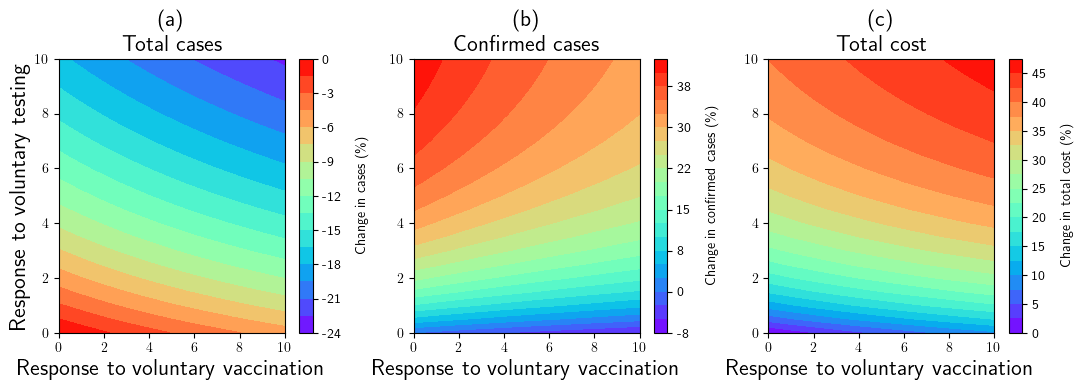

In [11]:
levels_ci = 21 
levels_tc = 21

fig, axs = plt.subplots(1,3,figsize=(11,4))
title_lable = ['(a) \n Total cases ', '(b) \n Confirmed cases ', '(c) \n Total cost ']
info_cove = [0.1, 0.51, 0.9]

for j in [0,1,2]:
    axs[0].set_ylabel(r'Response to voluntary testing ',fontsize=16,fontweight="bold")
    axs[j].set_xlabel(r'Response to voluntary vaccination',fontsize=16, fontweight="bold")
    axs[j].set_title(title_lable[j],fontsize=16, fontweight="bold")
    if j == 0:        
        img0 = axs[j].contourf(D_values, Dtilde_values, CI.T,levels=levels_ci,cmap = 'rainbow') #cmap = 'rainbow' 
        plt.colorbar(img0,format=tkr.FormatStrFormatter('%.0f')).set_label('Change in cases (\%) ', rotation= -270, labelpad=10)

        # Add contour line where percent change is zero
        # zero_contour = axs[j].contour(D_values, Dtilde_values, CI.T, levels=[0], colors='black', linewidths=2, linestyles='--')
        # axs[j].clabel(zero_contour, fmt = "Zero Change", fontsize=10, colors='black') 
        
    elif j == 1:            
        
        img0 = axs[j].contourf(D_values, Dtilde_values, Confirmed_cases.T, levels = levels_confirmed_case, cmap = 'rainbow') #cmap = 'rainbow' 
        plt.colorbar(img0,format=tkr.FormatStrFormatter('%.0f')).set_label('Change in confirmed cases (\%)', rotation= -270, labelpad=10)

        # Add contour line where percent change is zero
        # zero_contour = axs[j].contour(D_values, Dtilde_values, Confirmed_cases.T, levels=[0], colors='black', linewidths=2, linestyles='--')
        # axs[j].clabel(zero_contour, fmt = "Zero Change", fontsize=10, colors='black') 
        
    elif j == 2:            
        
        img0 = axs[j].contourf(D_values, Dtilde_values, Cost.T,levels=levels_ci,cmap = 'rainbow') #cmap = 'rainbow' 
        plt.colorbar(img0,format=tkr.FormatStrFormatter('%.0f')).set_label('Change in total cost (\%) ', rotation= -270, labelpad=10)

        # Add contour line where percent change is zero
        # zero_contour = axs[j].contour(D_values, Dtilde_values, Cost.T, levels=[0], colors='black', linewidths=2, linestyles='--')
        # axs[j].clabel(zero_contour, fmt = "Zero Change", fontsize=10, colors='black')

plt.tight_layout()
#plt.suptitle('Total cost per cumulative incidence with varying information coverage and priortiation by immune individuals',y =1.07, fontsize=16)
plt.savefig('Contour_effect_reactivity.pdf', bbox_inches='tight', pad_inches=0.1, dpi =600)
plt.show()